# Topic analysis of the hover event

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from empath import Empath
lexicon = Empath()

In [8]:
import codecs
import json
import random

records = []

file = codecs.open("link_level_pos_neg_hovers.json", "r", "utf-8")
for line in file:
    if random.randint(0, 10) < 5:
        tmp = line.replace("\n", " ")#.replace("\x85", " ")
        try:
            records.append(json.loads(tmp))
        except:
            pass

In [15]:
records[0:2]

[{u'hover': 1,
  u'quality': 0.585320637981267,
  u'text': u'The running of the department stores passed to a company called Ermes Department Stores Public Limited, and after an initial rebranding of the stores as Ermes, they were renamed a year later Debenhams.',
  u'top_macrotopic': u'History_And_Society',
  u'top_microtopic': u'Business and economics'},
 {u'hover': 0,
  u'quality': 0.26794219048459716,
  u'text': u'34 of 1989.',
  u'top_macrotopic': u'Culture',
  u'top_microtopic': u'Sports'}]

### Get Empath vectors

In [5]:
topics = []
c=0
for r in records:
    c+=1
    if c % 10000 == 0:
        print(c)
    if "top_macrotopic" in r:
        t = lexicon.analyze(r['text'], normalize=True)
        t["top_macrotopic"] = r['top_macrotopic']
        t["hover"] = r['hover']
        topics.append(t)

### For each topic, get difference from positive and negative

In [56]:
df = pd.DataFrame(topics)

pos = df[df.hover==1].drop("hover", axis=1).mean().reset_index().rename(columns={"index": "name", 0: "positive"})
neg = df[df.hover==0].drop("hover", axis=1).mean().reset_index().rename(columns={"index": "name", 0: "negative"})
by_topic = pos.merge(neg, on="name")
by_topic["diff"]=by_topic['positive']-by_topic['negative']

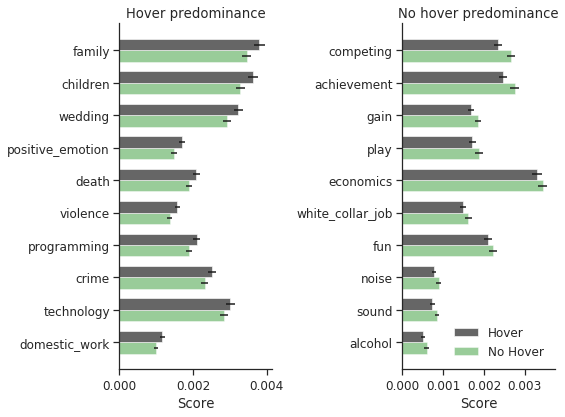

In [151]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h
# plt.figure(figsize=(5, 3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


fig, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

######
# Hover predominance
topK = by_topic.sort_values("diff", ascending=False).head(10).name.tolist()
top_topics = df[topK+['hover']]
top_topics_positive = top_topics[top_topics.hover==1]
top_topics_negative = top_topics[top_topics.hover==0]

pos = []

for f in topK:
    m, ci = mean_confidence_interval(top_topics_positive[f])
    pos.append({"name": f, "mean": m, "ci": ci})
    
pos = pd.DataFrame(pos)

neg = []

for f in topK:
    m, ci = mean_confidence_interval(top_topics_negative[f])
    neg.append({"name": f, "mean": m, "ci": ci})
    
neg = pd.DataFrame(neg)


labels = topK.copy()
labels.reverse()
positiveMeans = pos['mean'].tolist()
positiveStd = pos.ci.tolist()
positiveMeans.reverse()
positiveStd.reverse()
negativeMeans = neg['mean'].tolist()
negativeStd = neg.ci.tolist()
negativeMeans.reverse()
negativeStd.reverse()

ind = np.arange(len(labels))    # the x locations for the groups
width = 0.35         # the width of the bars
p2 = ax[0].barh(ind , negativeMeans, width, xerr=negativeStd, alpha=0.4, color="green")
p1 = ax[0].barh(ind+ width, positiveMeans, width, xerr=positiveStd, alpha=0.6, color="black")
ax[0].set_yticks(ind + width / 2)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel("Score")
ax[0].set_title("Hover predominance")

ax[0].autoscale_view()

######
# NO Hover predominance

topK = by_topic.sort_values("diff", ascending=True).head(10).name.tolist()
top_topics = df[topK+['hover']]
top_topics_positive = top_topics[top_topics.hover==1]
top_topics_negative = top_topics[top_topics.hover==0]

pos = []

for f in topK:
    m, ci = mean_confidence_interval(top_topics_positive[f])
    pos.append({"name": f, "mean": m, "ci": ci})
    
pos = pd.DataFrame(pos)

neg = []

for f in topK:
    m, ci = mean_confidence_interval(top_topics_negative[f])
    neg.append({"name": f, "mean": m, "ci": ci})
    
neg = pd.DataFrame(neg)


labels = topK.copy()
labels.reverse()
positiveMeans = pos['mean'].tolist()
positiveStd = pos.ci.tolist()
positiveMeans.reverse()
positiveStd.reverse()
negativeMeans = neg['mean'].tolist()
negativeStd = neg.ci.tolist()
negativeMeans.reverse()
negativeStd.reverse()

ind = np.arange(len(labels))    # the x locations for the groups
width = 0.35         # the width of the bars
p2 = ax[1].barh(ind , negativeMeans, width, xerr=negativeStd, alpha=0.4, color="green")
p1 = ax[1].barh(ind+ width, positiveMeans, width, xerr=positiveStd, alpha=0.6, color="black")
ax[1].set_yticks(ind + width / 2)
ax[1].set_yticklabels(labels)
ax[1].set_xlabel("Score")
ax[1].set_title("No hover predominance")

# ax[1].legend((p1[0], p2[0]), ('Hover', 'No Hover'))
ax[1].autoscale_view()

leg = ax[1].legend((p1[0], p2[0]), ('Hover', 'No Hover'))

# leg = .legend()
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

# plt.show()
plt.savefig('hover_topics.pdf', bbox_inches='tight')
